###Load Dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install -q kaggle


In [4]:
!kaggle datasets download -d tmdb/tmdb-movie-metadata

Dataset URL: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
License(s): other
  0% 0.00/8.89M [00:00<?, ?B/s]
100% 8.89M/8.89M [00:00<00:00, 1.75GB/s]


In [6]:
!unzip /content/tmdb-movie-metadata.zip

Archive:  /content/tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


###Start Reading data

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier



In [10]:
df = pd.read_csv("tmdb_5000_movies.csv")
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


#####Data Cleaning + Feature Engineering

In [45]:
# Select useful columns
df = df[['budget', 'revenue', 'runtime', 'release_date', 'genres', 'title']]
df = df.dropna()

In [34]:
# Drop missing values
df = df.dropna(subset=['budget', 'revenue', 'runtime', 'release_date', 'genres'])


In [48]:
# Convert release_date → month
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month'] = df['release_date'].dt.month
# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Create release_month column
df['release_month'] = df['release_date'].dt.month


In [46]:
# Target column (1 = Hit, 0 = Flop)
df['success'] = np.where(df['revenue'] > df['budget'], 1, 0)


In [49]:
# Features & Target
X = df[['budget', 'runtime', 'release_month', 'genres']]
y_class = df['success']   # Classification
y_reg = df['revenue']     # Regression

###Preprocessing Setup

In [51]:
numeric_features = ['budget', 'runtime', 'release_month']
categorical_features = ['genres']

In [52]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [53]:
# Extract main genre
import ast
def extract_genre(x):
    try:
        genres = ast.literal_eval(x)
        if len(genres) > 0:
            return genres[0]['name']
        else:
            return "Unknown"
    except:
        return "Unknown"

In [15]:
df['main_genre'] = df['genres'].apply(extract_genre)

In [17]:
# Create classification target: Hit (1) / Flop (0)
df['success'] = np.where(df['revenue'] >= df['budget'] * 1.5, 1, 0)

print("Cleaned Data Sample:")
df[['title', 'budget', 'revenue', 'main_genre', 'release_month', 'success']].head()


Cleaned Data Sample:


,title,budget,revenue,main_genre,release_month,success
0,Avatar,237000000.0,2.787965e+09,Action,12.0,1
1,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,Adventure,5.0,1
2,Spectre,245000000.0,8.806746e+08,Action,10.0,1
3,The Dark Knight Rises,250000000.0,1.084939e+09,Action,7.0,1
4,John Carter,260000000.0,2.841391e+08,Action,3.0,0


#### Regression → Predict Revenue

In [18]:
X_reg = df[['budget', 'runtime', 'release_month', 'main_genre']]
y_reg = df['revenue']

In [19]:
# Encoding + Scaling
preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), ['budget','runtime','release_month']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['main_genre'])
])

reg_model = Pipeline([
    ('preprocess', preprocessor_reg),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


####Classification → Hit or Flop

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

clf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

clf_pipeline.fit(X_train, y_train)
y_pred_class = clf_pipeline.predict(X_test)

print("🎯 Classification Report (Hit/Flop):")
print(classification_report(y_test, y_pred_class))

🎯 Classification Report (Hit/Flop):
              precision    recall  f1-score   support

           0       0.46      0.10      0.17       157
           1       0.77      0.96      0.85       489

    accuracy                           0.75       646
   macro avg       0.61      0.53      0.51       646
weighted avg       0.69      0.75      0.69       646



In [21]:
X_cls = df[['budget', 'runtime', 'release_month', 'main_genre']]
y_cls = df['success']

In [22]:
# Encoding + Scaling
preprocessor_cls = ColumnTransformer([
    ('num', StandardScaler(), ['budget','runtime','release_month']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['main_genre'])
])

cls_model = Pipeline([
    ('preprocess', preprocessor_cls),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

cls_model.fit(X_train, y_train)
y_pred_cls = cls_model.predict(X_test)

print("\n📊 Classification Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_cls))
print(classification_report(y_test, y_pred_cls))


📊 Classification Results:
Accuracy: 0.6021671826625387
              precision    recall  f1-score   support

           0       0.40      0.28      0.33       227
           1       0.67      0.78      0.72       419

    accuracy                           0.60       646
   macro avg       0.53      0.53      0.52       646
weighted avg       0.57      0.60      0.58       646



######Confusion Matrix

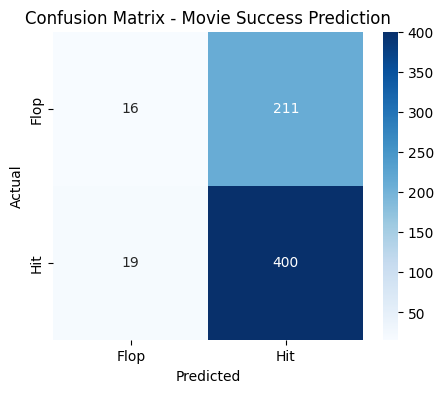

In [56]:
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Flop", "Hit"], yticklabels=["Flop", "Hit"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Movie Success Prediction")
plt.show()

##### Evaluate Metrics

## Feature Importance (Classification)

In [62]:
model = clf_pipeline.named_steps['classifier']
importances = model.feature_importances_


In [67]:
# Get feature names properly
num_features = ['budget', 'runtime', 'release_month']
cat_encoder = clf_pipeline.named_steps['preprocessor'].transformers_[1][1]  # OneHotEncoder object
cat_features = list(cat_encoder.get_feature_names_out(['genres']))
all_features = num_features + cat_features


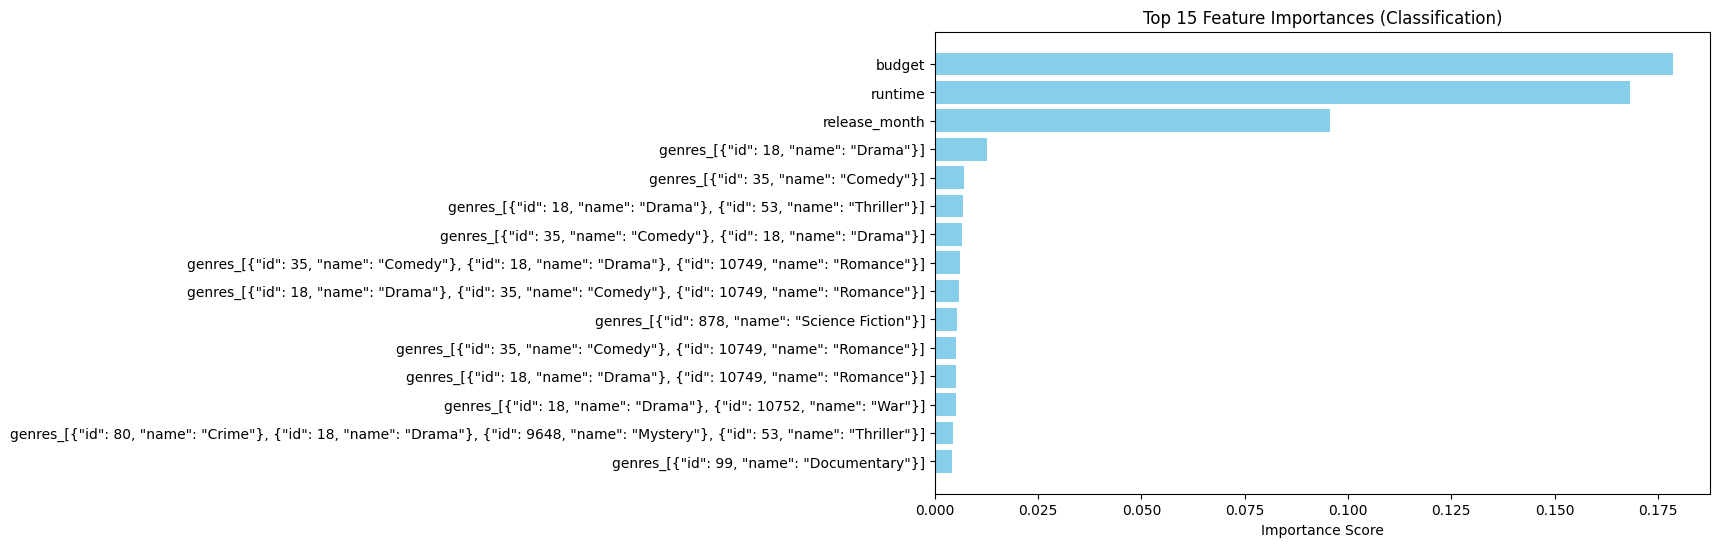

In [68]:
# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot Top 15 Features
plt.figure(figsize=(10,6))
plt.barh(np.array(all_features)[indices][:15], importances[indices][:15], color="skyblue")
plt.title("Top 15 Feature Importances (Classification)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()

###Regression Model (Revenue Prediction)

In [57]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])


In [58]:
reg_pipeline.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_pipeline.predict(X_test_reg)

print("📊 Regression Performance:")
print("R2 Score:", r2_score(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))


📊 Regression Performance:
R2 Score: 0.5196084929191411
RMSE: 155825189.94306952


 ## Feature Importance (Regression)

In [69]:
# Model trained inside pipeline
reg_model = reg_pipeline.named_steps['regressor']

# Feature importances
reg_importances = reg_model.feature_importances_


In [70]:
# Feature names (same as classification)
num_features = ['budget', 'runtime', 'release_month']
cat_encoder = reg_pipeline.named_steps['preprocessor'].transformers_[1][1]  # OneHotEncoder
cat_features = list(cat_encoder.get_feature_names_out(['genres']))

all_features = num_features + cat_features

# Sort by importance
indices = np.argsort(reg_importances)[::-1]


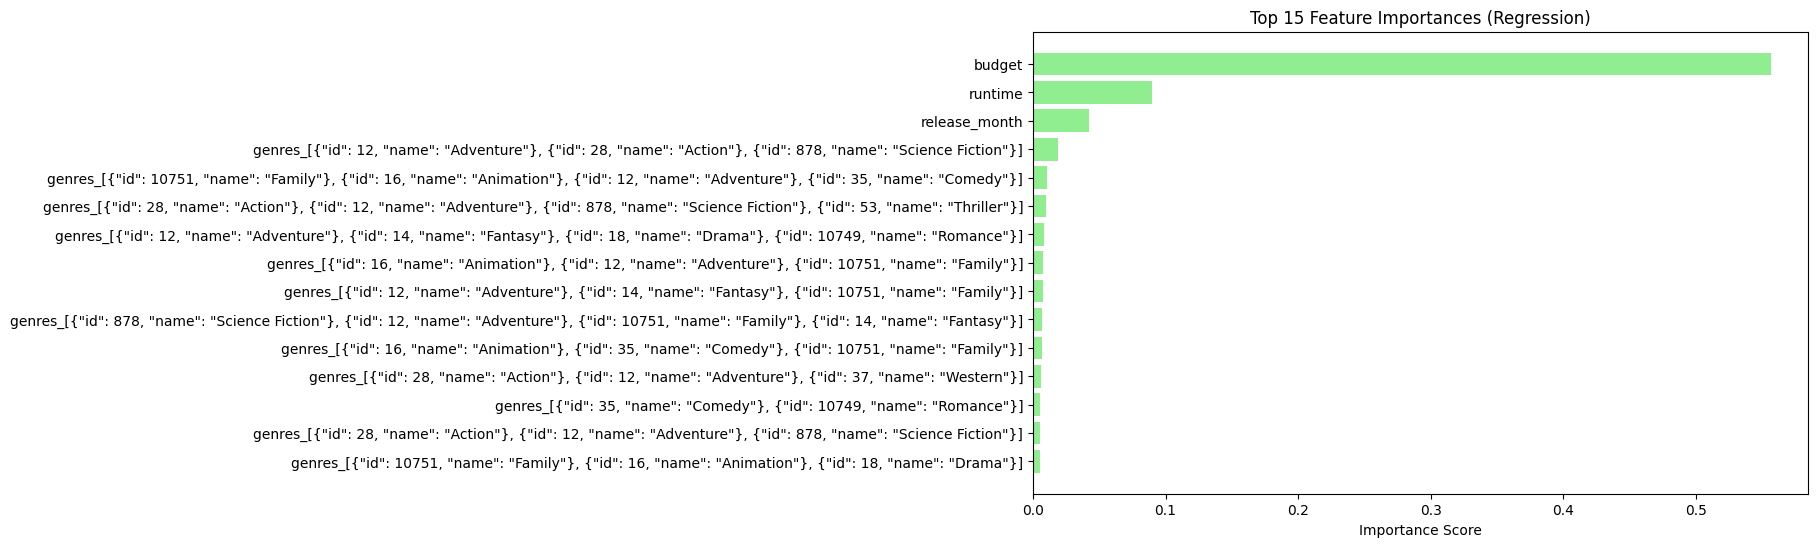

In [71]:
# Plot Top 15 Features
plt.figure(figsize=(10,6))
plt.barh(np.array(all_features)[indices][:15], reg_importances[indices][:15], color="lightgreen")
plt.title("Top 15 Feature Importances (Regression)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()

##Visualizations

/tmp/ipython-input-849618435.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  budget_rev = df.groupby('budget_bins')['revenue'].mean()


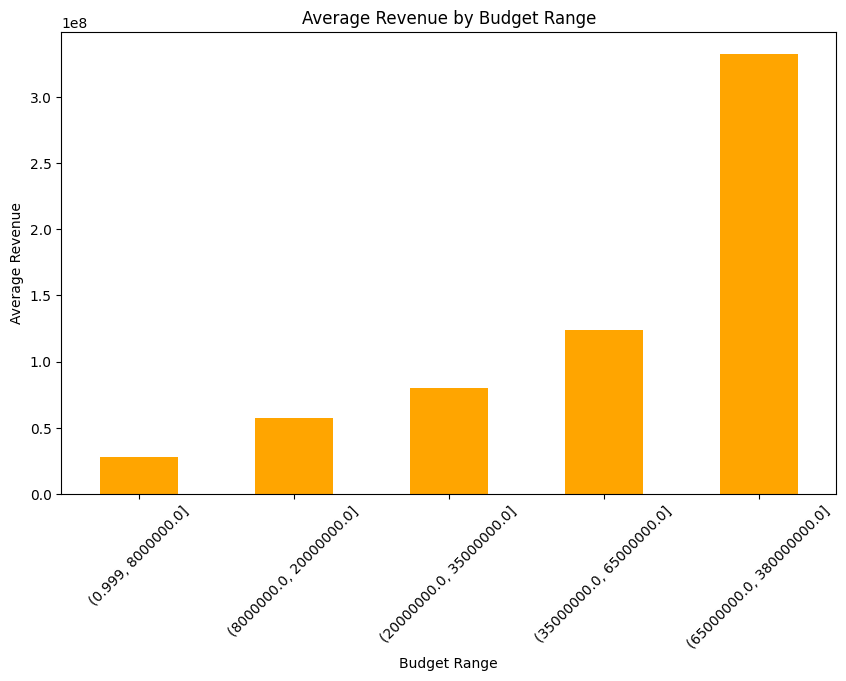

In [81]:

# Budget bins
df['budget_bins'] = pd.qcut(df['budget'], q=5, duplicates='drop')

# Group by bins
budget_rev = df.groupby('budget_bins')['revenue'].mean()

# Bar Plot
plt.figure(figsize=(10,6))
budget_rev.plot(kind='bar', color="orange")
plt.title("Average Revenue by Budget Range")
plt.xlabel("Budget Range")
plt.ylabel("Average Revenue")
plt.xticks(rotation=45)
plt.show()


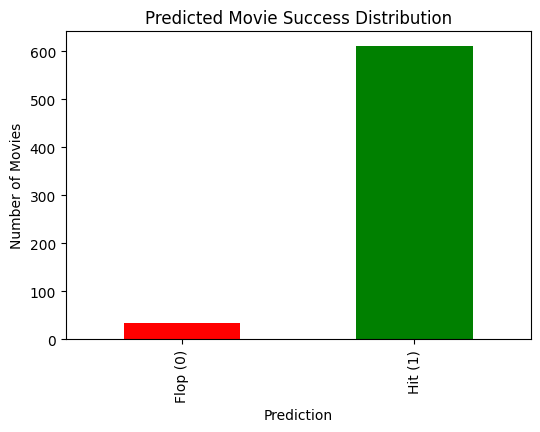

In [82]:
# Bar graph for classification results (Hit vs Flop)
pred_counts = pd.Series(y_pred_class).value_counts().sort_index()
pred_counts.index = ["Flop (0)", "Hit (1)"]

plt.figure(figsize=(6,4))
pred_counts.plot(kind="bar", color=["red","green"])
plt.title("Predicted Movie Success Distribution")
plt.xlabel("Prediction")
plt.ylabel("Number of Movies")
plt.show()


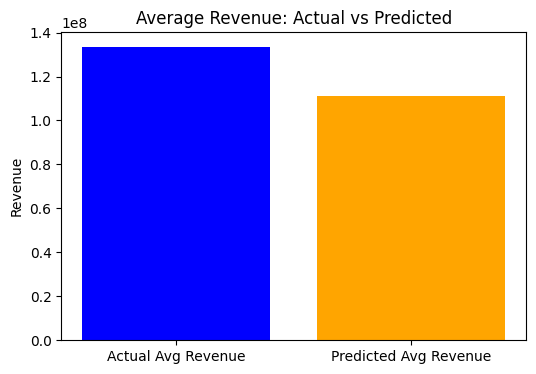

In [84]:
# Compare average actual vs predicted revenue using bar graph
avg_actual = y_test_reg.mean()
avg_pred = y_pred_reg.mean()

plt.figure(figsize=(6,4))
plt.bar(["Actual Avg Revenue", "Predicted Avg Revenue"], [avg_actual, avg_pred], color=["blue","orange"])
plt.title("Average Revenue: Actual vs Predicted")
plt.ylabel("Revenue")
plt.show()


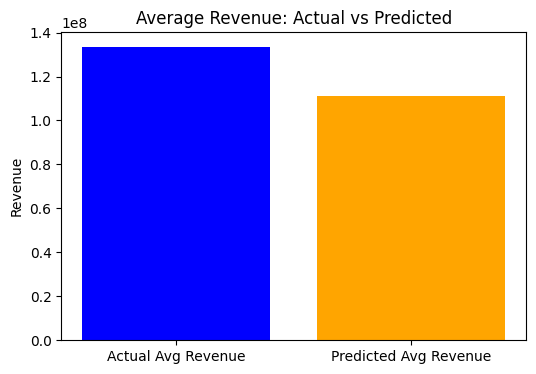

In [86]:
# Compare average actual vs predicted revenue using bar graph
avg_actual = y_test_reg.mean()
avg_pred = y_pred_reg.mean()

plt.figure(figsize=(6,4))
plt.bar(["Actual Avg Revenue", "Predicted Avg Revenue"], [avg_actual, avg_pred], color=["blue","orange"])
plt.title("Average Revenue: Actual vs Predicted")
plt.ylabel("Revenue")
plt.show()


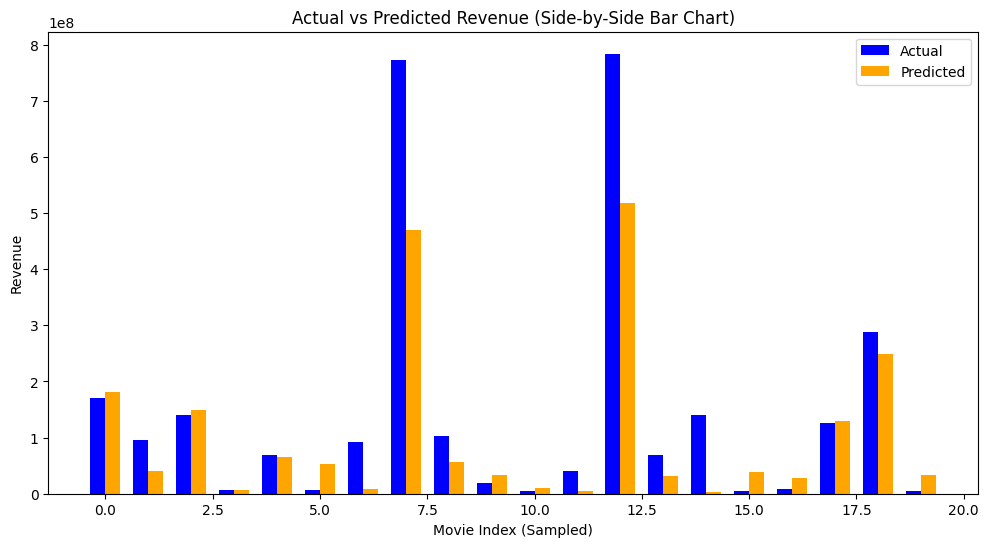

In [87]:

# Side-by-side bar chart for Actual vs Predicted Revenue
indices = np.arange(len(y_test_reg[:20]))  # sirf pehli 20 movies dikhayenge clarity ke liye
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(indices - width/2, y_test_reg[:20], width, label="Actual", color="blue")
plt.bar(indices + width/2, y_pred_reg[:20], width, label="Predicted", color="orange")

plt.xlabel("Movie Index (Sampled)")
plt.ylabel("Revenue")
plt.title("Actual vs Predicted Revenue (Side-by-Side Bar Chart)")
plt.legend()
plt.show()


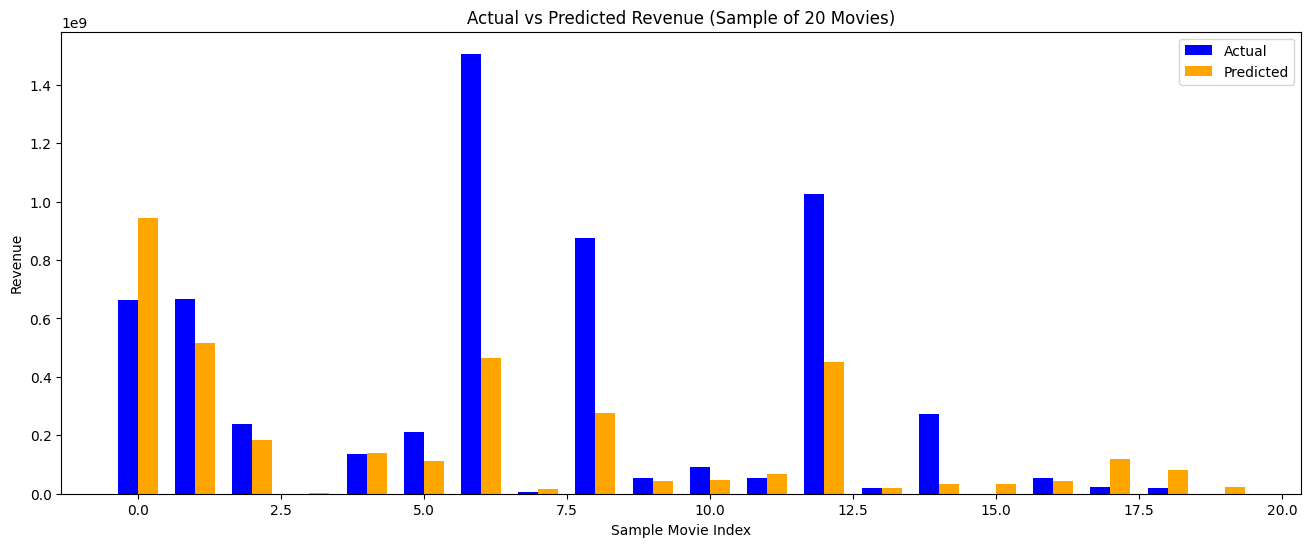

In [91]:
# Sample comparison of Actual vs Predicted Revenue (Bar Chart)
sample_indices = np.random.choice(len(y_test_reg), size=20, replace=False)

plt.figure(figsize=(16,6))
width = 0.35

plt.bar(np.arange(len(sample_indices)) - width/2,
        y_test_reg.iloc[sample_indices],
        width,
        label="Actual",
        color="blue")

plt.bar(np.arange(len(sample_indices)) + width/2,
        y_pred_reg[sample_indices],
        width,
        label="Predicted",
        color="orange")

plt.xlabel("Sample Movie Index")
plt.ylabel("Revenue")
plt.title("Actual vs Predicted Revenue (Sample of 20 Movies)")
plt.legend()
plt.show()


# Data Preparation

In [92]:
from sklearn.model_selection import train_test_split

# Example: Classification (Hit/Flop)
X = df[['budget','runtime','release_month','genres']]
y = df['success']  # 1 = Hit, 0 = Flop

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Preprocessing

In [93]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = ['budget','runtime','release_month']
categorical_features = ['genres']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


## Decision Tree Classifier

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Pipeline with preprocessing + model
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train
dt_pipeline.fit(X_train, y_train)

# Predict
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.6981424148606811
              precision    recall  f1-score   support

           0       0.29      0.17      0.21       157
           1       0.76      0.87      0.81       489

    accuracy                           0.70       646
   macro avg       0.53      0.52      0.51       646
weighted avg       0.65      0.70      0.67       646



## Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7554179566563467
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       157
           1       0.76      1.00      0.86       489

    accuracy                           0.76       646
   macro avg       0.55      0.50      0.44       646
weighted avg       0.65      0.76      0.65       646



## Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7523219814241486
              precision    recall  f1-score   support

           0       0.46      0.10      0.17       157
           1       0.77      0.96      0.85       489

    accuracy                           0.75       646
   macro avg       0.61      0.53      0.51       646
weighted avg       0.69      0.75      0.69       646



# Define a Function for Prediction

In [99]:
def predict_movie(budget, runtime, release_month, genre):
    """
    budget: int
    runtime: int
    release_month: 1-12
    genre: string e.g., 'Action'
    """
    import pandas as pd
    import numpy as np

    # Create single row DataFrame
    user_df = pd.DataFrame({
        'budget': [budget],
        'runtime': [runtime],
        'release_month': [release_month],
        'genres': [genre]
    })

    # Classification prediction
    hit_flop = clf_pipeline.predict(user_df)[0]
    hit_prob = clf_pipeline.predict_proba(user_df)[0][1]  # probability of Hit

    # Regression prediction
    revenue_pred = reg_pipeline.predict(user_df)[0]

    return hit_flop, hit_prob, revenue_pred


# Get User Input in Colab

In [108]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Get list of movie titles
movie_titles = df['title'].tolist()

# -------------------
# Widget for text input
movie_input = widgets.Text(
    value='',
    placeholder='Type movie name...',
    description='Movie:',
    disabled=False
)

# Widget for suggestions (Dropdown)
suggestion_dropdown = widgets.Dropdown(
    options=[],
    description='Suggestions:',
    disabled=False
)

predict_button = widgets.Button(
    description='Predict',
    button_style='success'
)

output = widgets.Output()

# -------------------
# Update suggestions as user types
def update_suggestions(change):
    typed = change['new']
    matches = [title for title in movie_titles if typed.lower() in title.lower()]
    suggestion_dropdown.options = matches[:10]  # max 10 suggestions

movie_input.observe(update_suggestions, names='value')

# -------------------
# Prediction function using selected suggestion
def on_button_click(b):
    output.clear_output()
    with output:
        if suggestion_dropdown.value:
            predict_movie_dashboard(suggestion_dropdown.value)
        else:
            print("Please select a movie from suggestions!")

predict_button.on_click(on_button_click)

# -------------------
# Display widgets
display(movie_input, suggestion_dropdown, predict_button, output)


Text(value='', description='Movie:', placeholder='Type movie name...')

Dropdown(description='Suggestions:', options=(), value=None)

Button(button_style='success', description='Predict', style=ButtonStyle())

Output()